# Example - Sentinel 2 Collection

In [1]:
import sentinel_collection as sc
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import planetary_computer
import s2_functions

The `s2` class requires a cloud cover threshold and a year to be created, the cloud cover threshold will be evaluated as 'less than' to compute cloud cover percentage at the area of interest based on SCL: Scene classification layer, provided by ESA.

We can use the `map` function to create many instances based on a list of cloud cover values.

In [2]:
year = ['2018', '2020', '2021']
cloud_cover = [15] * 3
data = list(map(sc.s2, cloud_cover, year))

Processing year: 2018-01-01/2018-12-31
Processing complete
Processing year: 2020-01-01/2020-12-31
Processing complete
Processing year: 2021-01-01/2021-12-31
Processing complete


The main attribute of this class is `stack` which stores a stackstac-xarray object that contains a data cube of Sentinel 2 L2A Collection filtered for the year specified and to the study area. In addition, the cloud cover threshold is specific for the study area, and not the entire tile.

In [3]:
data[0].stack

<xarray.DataArray 'stackstac-e699fe4a82f03ab187a0d718c1407d9d' (time: 34,
                                                                band: 10,
                                                                y: 4513, x: 5183)>
dask.array<getitem, shape=(34, 10, 4513, 5183), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
  * band                                     (band) <U7 'B02' 'B03' ... 'B12'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    proj:epsg                                int64 32630
    ...                                       ...
    proj:shape                               (band) object [10980, 10980] ......
    gsd                                      (band) object 10.0 10.0 ... 20.0
    common_name                              (band) object 'blue' ... 'swir22'
    center_wavelength                        (band) object 0.49 0.56 ... 2.19
    full_width_half_max                      (band) object 0.098 0.045 ... 0.242
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

As we can see, the xarray data cube has 4 dimensions (time, bands, x, y), on the time dimention there are 34 objects, meaning that there are 34 images that match our cloud cover criteria for the year 2018, each image has 10 bands (10 and 20 meters bands), and the images consists of 4513x5183 pixels.

The computation of the AOI cloud cover is done using the Scene Classification Layer (SCL) provided by ESA, this layer contains 12 classes:

| Bit value | Class |
|---|---|
| 0 | No data |
| 1 | Saturated or defective |
| 2 | Dark area pixels |
| 3 | Cloud shadows |
| 4 | Vegetation |
| 5 | Bare Soil |
| 6 | Water |
| 7 | Unclassified |
| 8 | Cloud medium probability |
| 9 | cloud high probability |
| 10 | Thin cirrus |
| 11 | Snow or ice |

The `stack` attribute is created using the `getReducedStack()` function defined in `s2_functions.py`. This function filters the SCL band to get create a cloud mask using the values 1, 3, 8, and 9. The SCL band and the mask are also stored in the attributes `SCL` and `mask` respectively.

In [4]:
data[0].SCL

<xarray.DataArray 'stackstac-e699fe4a82f03ab187a0d718c1407d9d' (time: 34,
                                                                y: 4513, x: 5183)>
dask.array<getitem, shape=(34, 4513, 5183), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/46)
  * time                                     (time) datetime64[ns] 2018-01-05...
    id                                       (time) <U54 'S2A_MSIL2A_20180105...
    band                                     <U7 'SCL'
  * x                                        (x) float64 4.026e+05 ... 4.544e+05
  * y                                        (y) float64 1.257e+06 ... 1.212e+06
    proj:epsg                                int64 32630
    ...                                       ...
    proj:shape                               object [5490, 5490]
    gsd                                      object 20.0
    common_name                              object None
    center_wavelength                        object None
    full_width_half_max                      object None
    epsg                                     int64 32630
Attributes:
    spec:        RasterSpec(epsg=32630, bounds=(402570, 1212060, 454400, 1257...
    crs:         epsg:32630
    transform:   | 10.00, 0.00, 402570.00|\n| 0.00,-10.00, 1257190.00|\n| 0.0...
    resolution:  10

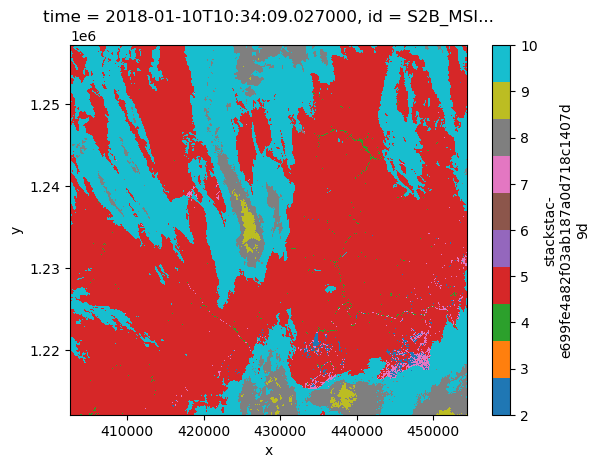

In [5]:
data[0].SCL[1, :, :].plot.imshow(cmap = 'tab10')

Here an example of one cloudy image:

Text(0, 0.5, '')

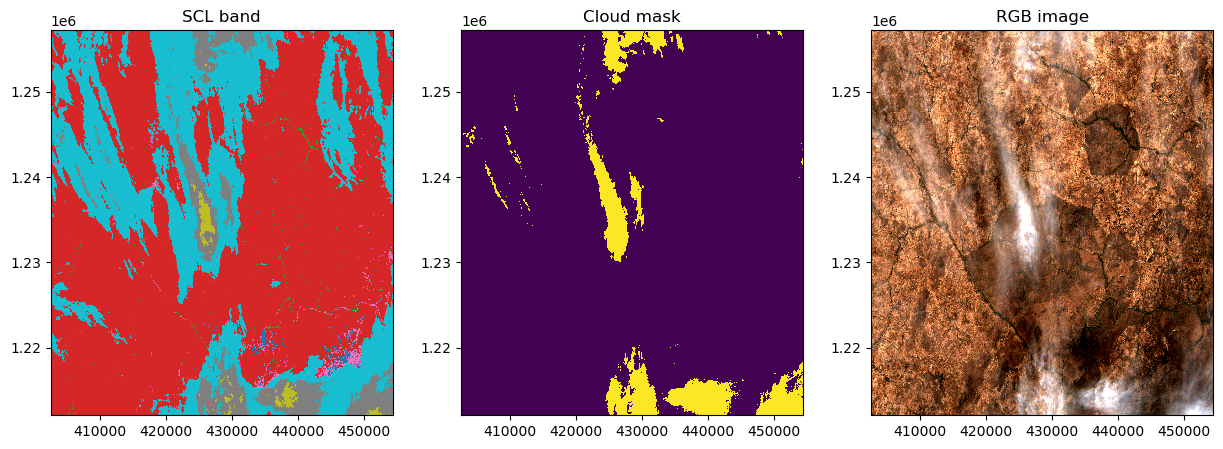

In [6]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
data[0].SCL[1, :, :].plot.imshow(cmap = 'tab10', ax = ax[0], add_colorbar = False)
ax[0].set_title('SCL band')
ax[0].set_xlabel('')
ax[0].set_ylabel('')
data[0].mask[1, :, :].plot.imshow(ax = ax[1], add_colorbar = False)
ax[1].set_title('Cloud mask')
ax[1].set_xlabel('')
ax[1].set_ylabel('')
data[0].stack[1, :, :, :].sel(band = ['B04', 'B03', 'B02']).plot.imshow(rgb="band", robust=True, ax = ax[2])
ax[2].set_title('RGB image')
ax[2].set_xlabel('')
ax[2].set_ylabel('')

The cloud percentage is computed by summing the pixel values of the mask and dividing by the total number of pixels. The image above has ~7 % of cloud cover.

In [7]:
data[0].bbox_cloud_cover[1]

7.0601964124563255

If we compare the number of images that are filtered using the cloud cover measure at the tile level with the AOI level we get the following results for a threshold of 15 percent.

In [8]:
print('Total # of images: ', len(s2_functions.getSearch(cloud_cover=100).item_collection()))
print('# of images using tile level cloud cover: ', len(s2_functions.getSearch(cloud_cover=15).item_collection()))
print('# of images using AOI level cloud cover: ', len(data[0].doy))

Total # of images:  69
# of images using tile level cloud cover:  25
# of images using AOI level cloud cover:  34


We can compare the available images in our full collection by accessing the information of `doy`.

In [9]:
inter = np.intersect1d(np.intersect1d(data[0].doy, data[1].doy), data[2].doy + 1)

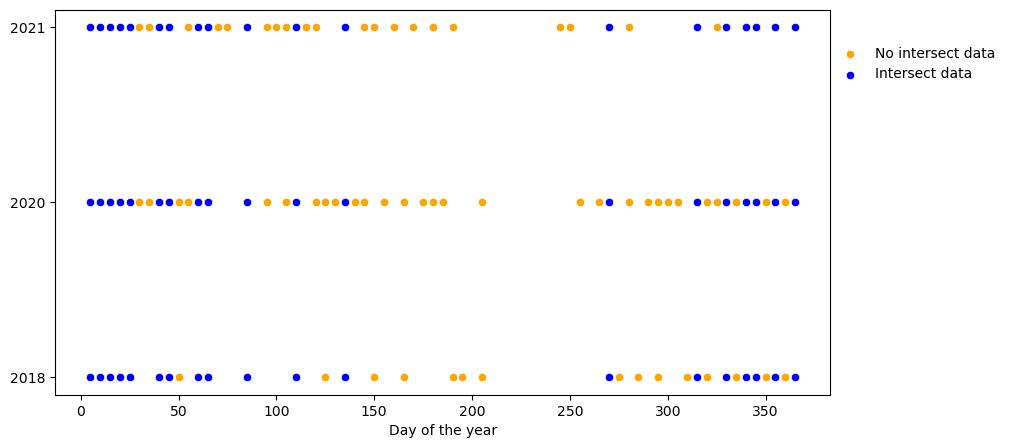

In [46]:
plt.figure(figsize= (10, 5))

for i, dat in enumerate(data):
    if i == 2:
        sns.scatterplot(x = dat.doy + 1, y = i, color = 'orange')
        sns.scatterplot(x = inter, y = i, color = 'b')
    else:
        sns.scatterplot(x = dat.doy, y = i, color = 'orange')
        sns.scatterplot(x = inter, y = i, color = 'b')

plt.yticks(ticks = [0, 1, 2], labels = ['2018', '2020', '2021'])
plt.xlabel('Day of the year')
plt.legend(["No intersect data", "Intersect data"], loc=(1,0.8), frameon=False)

In [14]:
union = np.union1d(np.union1d(data[0].doy, data[1].doy), data[2].doy + 1)

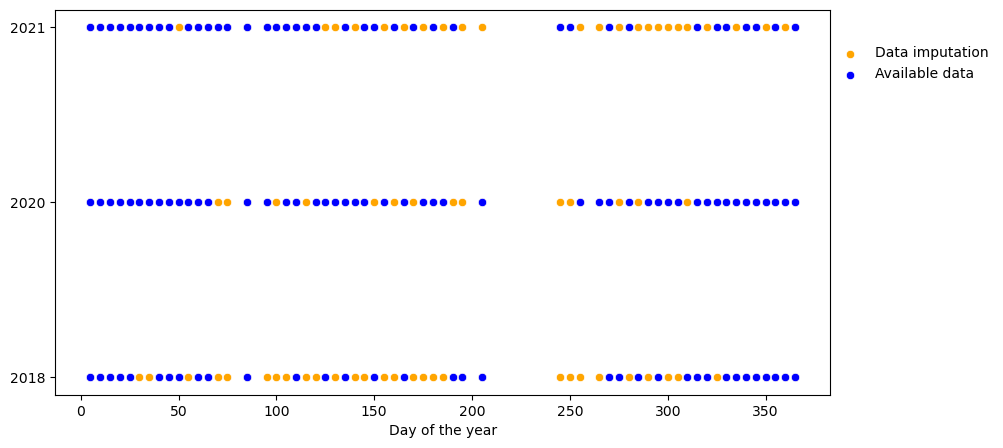

In [43]:
plt.figure(figsize= (10, 5))

for i, dat in enumerate(data):
    if i == 2:
        sns.scatterplot(x = union, y = i, color = 'orange')
        sns.scatterplot(x = dat.doy +1, y = i, color = 'b')
    else:
        sns.scatterplot(x = union, y = i, color = 'orange')
        sns.scatterplot(x = dat.doy, y = i, color = 'b')
    

plt.yticks(ticks = [0, 1, 2], labels = ['2018', '2020', '2021'])
plt.xlabel('Day of the year')
plt.legend(["Data imputation", "Available data"], loc=(1,0.8), frameon=False)

In [30]:
not2018 = np.setdiff1d(union, data[0].doy)
not2020 = np.setdiff1d(union, data[1].doy)
not2021 = np.setdiff1d(union, data[2].doy +1)
print(len(not2018), len(not2020), len(not2021))

28 14 23


In [47]:
union.shape

(62,)